In [20]:
import numpy as np
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery, LeftRightImagery
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mne.decoding import CSP

In [21]:
##########################
# Step 1: Load dataset
##########################
dataset = BNCI2014_001()  
paradigm = MotorImagery()
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[2], return_epochs=True)

# If X is an MNE Epochs object, convert it to a NumPy array
if not isinstance(X, np.ndarray):
    X = X.get_data()

Choosing from all possible events


Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied


/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 48 events (all good), 2 – 6 s (baseline off), ~8.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12
 'feet': 12
 'tongue': 12>
  warn(f"warnEpochs {epochs}")
/home/vishwa/anaconda3/envs/eeg_proj/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: Use

In [22]:

##########################
# Step 2: Euclidean Alignment
##########################
# Compute the arithmetic mean of per-trial covariance matrices
covs = np.array([trial @ trial.T for trial in X])  # shape [n_trials, n_channels, n_channels]
mean_cov = np.mean(covs, axis=0)

# Eigen-decomposition of mean_cov
eigvals, eigvecs = np.linalg.eigh(mean_cov)
D_inv_sqrt = np.diag(eigvals**(-0.5))
R_inv_sqrt = eigvecs @ D_inv_sqrt @ eigvecs.T

# Align each trial
X_aligned = np.array([R_inv_sqrt @ trial for trial in X])

In [23]:

##########################
# Step 3: CSP Feature Extraction
##########################
n_components = 4
csp = CSP(n_components=n_components, reg=None, log=True, norm_trace=False)
features = csp.fit_transform(X_aligned, labels)

Computing rank from data with rank=None


    Using tolerance 0.12 (2.2e-16 eps * 22 dim * 2.4e+13  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=feet covariance using EMPIRICAL
Done.
Estimating class=left_hand covariance using EMPIRICAL
Done.
Estimating class=right_hand covariance using EMPIRICAL
Done.
Estimating class=tongue covariance using EMPIRICAL
Done.


In [24]:

##########################
# Step 4: Train LDA
##########################
lda = LinearDiscriminantAnalysis()
lda.fit(features, labels)
acc = lda.score(features, labels) * 100
print(f"Training accuracy on single-subject data: {acc:.2f}%")

Training accuracy on single-subject data: 59.55%


/tmp/ipykernel_27474/2495128333.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(tsne_raw[:, 0], tsne_raw[:, 1], c=colors, cmap='tab10')
/tmp/ipykernel_27474/2495128333.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(tsne_aligned[:, 0], tsne_aligned[:, 1], c=colors, cmap='tab10')


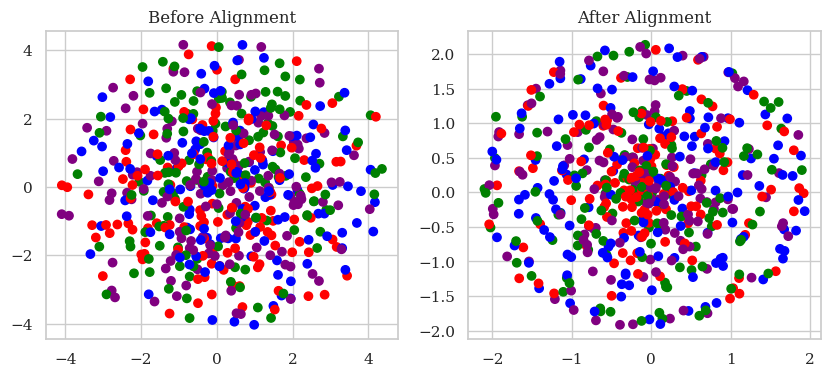

In [25]:
##########################
# Step 5: t-SNE Visualization
##########################
def flatten_trials(data):
    return data.reshape(data.shape[0], -1)

X_raw_flat = flatten_trials(X)
X_aligned_flat = flatten_trials(X_aligned)

tsne_raw = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_raw_flat)
tsne_aligned = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_aligned_flat)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
color_map = {
    'tongue': 'red',
    'feet': 'blue',
    'left_hand': 'green',
    'right_hand': 'purple'
}

# Map your labels to colors
colors = [color_map[label] for label in labels]

# Use numeric labels for coloring
axes[0].scatter(tsne_raw[:, 0], tsne_raw[:, 1], c=colors, cmap='tab10')
axes[0].set_title('Before Alignment')
axes[1].scatter(tsne_aligned[:, 0], tsne_aligned[:, 1], c=colors, cmap='tab10')
axes[1].set_title('After Alignment')
plt.show()